In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import sys
sys.path.append('/mnt/nvme2tb/ffp/code/mlfires/ML_fires_al')
import fileutils
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score
import matplotlib.pyplot as plt

In [2]:
def cmvals(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape[0]==1 and y_true[0]==0:
        tn = cm[0,0]
        fp = 0
        fn = 0
        tp = 0
    elif cm.shape[0]==1 and y_true[0]==1:
        tn = 0
        fp = 0
        fn = 0
        tp = cm[0,0]
    elif cm.shape[0]==2:
        tn = cm[0, 0]
        fp = cm[0, 1]
        fn = cm[1, 0]
        tp = cm[1, 1]
    else:
        tn=fp=fn=tp=None
    return tn, fp, fn, tp

def calc_all_hybrids(rec_1, rec_0, debug=True):
    hybrid1 = hybridrecall(1, 1, rec_1, rec_0)
    hybrid2 = hybridrecall(2, 1, rec_1, rec_0)
    hybrid5 = hybridrecall(5, 1, rec_1, rec_0)
    nh2 = hybridrecall(2, 1, rec_1, rec_0, 'NH')
    nh5 = hybridrecall(5, 1, rec_1, rec_0, 'NH')
    nh10 = hybridrecall(10, 1, rec_1, rec_0, 'NH')
    ba = hybridrecall(1, 1, rec_1, rec_0, 'NH')

    if debug:
        print("hybrid1 : %.2f" % hybrid1)
        print("hybrid2 : %.2f" % hybrid2)
        print("hybrid5 : %.2f" % hybrid5)
        print("NH 2 : %.2f" % nh2)
        print("NH 5 : %.2f" % nh5)
        print("NH 10 : %.2f" % nh10)
        print("BA : %.2f" % ba)
    return hybrid1, hybrid2, hybrid5, nh2, nh5, nh10, ba

def hybridrecall(w1, w0, rec1, rec0, hybtype = 'hybrid'):
    if hybtype == 'hybrid':
        if rec1 > 0 and rec0 > 0:
            return (w1 + w0) / (w1 / rec1 + w0 / rec0)
        else:
            return -1000
    elif hybtype == 'NH':
        return w1*rec1 + w0*rec0
    else:
        return -1000

def calc_metrics(y, y_scores, y_pred, numaucthres=200, debug=True, calc_hybrids = False):
    if debug:
        print("calulating metrics from scores (sklearn)")
        print("calulating tn, fp, fn, tp")
    tn, fp, fn, tp = cmvals(y, y_pred)
    if debug:
        print("tn : %d, fp : %d, fn : %d, tp : %d" % (tn, fp, fn, tp))
    #tnK, fpK, fnK, tpK = cmvals_tf(y, y_pred)
    #if debug:
    #    print("ksum tn : %d, fp : %d, fn : %d, tp : %d" % (tnK, fpK, fnK, tpK))
    '''
    if debug:
        print("calulating auc...")
    if numaucthres>0:
        aucmetric = AUC(num_thresholds=numaucthres)
        aucmetric.update_state(y, y_scores[:, 1])
        auc = float(aucmetric.result())
    else:
        auc = 0.0
    if debug:
        print("auc : %.2f" % auc)
    '''
    auc=0
    if debug:
        print("calulating accuracy...")
    acc = accuracy_score(y, y_pred)
    #acc_0 = accuracy_score(1 - y, 1 - y_pred)
    if debug:
        print("accuracy : %.2f" % acc)
        #print("accuracy 0 : %.2f" % acc_0)
    if debug:
        print("calulating recall...")
    rec_1 = recall_score(y, y_pred)
    rec_0 = recall_score(1 - y, 1 - y_pred)
    if debug:
        print("recall 1 : %.2f" % rec_1)
        print("recall 0 : %.2f" % rec_0)
    if debug:
        print("calulating precision...")
    prec_1 = precision_score(y, y_pred)
    prec_0 = precision_score(1 - y, 1 - y_pred)
    if debug:
        print("precision 1 : %.2f" % prec_1)
        print("precision 0 : %.2f" % prec_0)
    if debug:
        print("calulating f1 score...")
    f1_1 = f1_score(y, y_pred)
    f1_0 = f1_score(1 - y, 1 - y_pred)
    if debug:
        print("f1 1 : %.2f" % f1_1)
        print("f1 0 : %.2f" % f1_0)
    if calc_hybrids:
        if debug:
            print("calulating hybrids...")
            hybrid1, hybrid2, hybrid5, nh2, nh5, nh10, ba = calc_all_hybrids(rec_1, rec_0, debug)
        if calc_hybrids:
            return auc, acc, prec_1, prec_0, rec_1, rec_0, f1_1, f1_0, hybrid1, hybrid2, hybrid5, nh2, nh5, nh10, ba, tn, fp, fn, tp
    else:
        return auc, acc, prec_1, prec_0, rec_1, rec_0, f1_1, f1_0, tn, fp, fn, tp

In [3]:
def filelist(directory, pattern):
    fl=[]
    for f in fileutils.find_files(directory, pattern, listtype="walk"):
        fl.append(f)
    return fl 

In [4]:
def applyid(df):
    df['xposst'] = (df['x'] * 10000).apply('{:06.0f}'.format)
    df['yposst'] = (df['y'] * 10000).apply('{:06.0f}'.format)
    df['id'] = df['xposst'] + df['yposst']
    df.drop(columns=['xposst', 'yposst'], inplace=True)
    return df

In [5]:
firesfold='/mnt/nvme2tb/ffp/datasets/fires2023'
prodfold='/mnt/nvme2tb/ffp/datasets/prod/pred2023/'
firefiles=filelist(firesfold, '*_fire.nc')
predfiles=filelist(prodfold, '*_pred_greece.csv')

In [6]:
dfeval=None
cnt=0
for f in predfiles:
    cnt+=1
    #if cnt>10: break
    print(cnt,f)
    date=os.path.basename(f)[:8]
    dfpred = pd.read_csv(f, dtype={'id':str})
    firefile=os.path.join(firesfold,'%s_fire.nc'%date)
    dfpred['date']=date
    if os.path.isfile(firefile):
        ds = xr.open_dataset(firefile)
        print(' ', firefile)
        df=ds.to_dataframe().reset_index()
        dffire=df[df['fire']==1].copy()
        applyid(dffire)
        dfm=pd.merge(dfpred,dffire, on='id', how='left', suffixes=("","_y"))
        dfm.drop(columns=[c for c in dfm.columns if c.endswith("_y")], inplace=True)
        dfm['fire'].fillna(0, inplace=True)
        dfm['fire']=dfm['fire'].astype(np.int8)
    else:
        dfm=dfpred
        dfm['fire']=0
    dfeval=pd.concat([dfeval, dfm])

1 /mnt/nvme2tb/ffp/datasets/prod/pred2023/20230727_pred_greece.csv
  /mnt/nvme2tb/ffp/datasets/fires2023/20230727_fire.nc
2 /mnt/nvme2tb/ffp/datasets/prod/pred2023/20230823_pred_greece.csv
  /mnt/nvme2tb/ffp/datasets/fires2023/20230823_fire.nc
3 /mnt/nvme2tb/ffp/datasets/prod/pred2023/20230718_pred_greece.csv
  /mnt/nvme2tb/ffp/datasets/fires2023/20230718_fire.nc
4 /mnt/nvme2tb/ffp/datasets/prod/pred2023/20230910_pred_greece.csv
  /mnt/nvme2tb/ffp/datasets/fires2023/20230910_fire.nc
5 /mnt/nvme2tb/ffp/datasets/prod/pred2023/20230802_pred_greece.csv
6 /mnt/nvme2tb/ffp/datasets/prod/pred2023/20230927_pred_greece.csv
7 /mnt/nvme2tb/ffp/datasets/prod/pred2023/20230720_pred_greece.csv
8 /mnt/nvme2tb/ffp/datasets/prod/pred2023/20230809_pred_greece.csv
9 /mnt/nvme2tb/ffp/datasets/prod/pred2023/20230919_pred_greece.csv
10 /mnt/nvme2tb/ffp/datasets/prod/pred2023/20230724_pred_greece.csv
11 /mnt/nvme2tb/ffp/datasets/prod/pred2023/20230814_pred_greece.csv
12 /mnt/nvme2tb/ffp/datasets/prod/pred202

In [7]:
y_pred=(dfeval['ypred1'].values > 0.5).astype(np.int8)

In [9]:
dfeval[dfeval['fire']==1]

,id,ypred0,ypred1,x,y,risk,date,fire
29723,208790392558,0.024203,0.975797,20.8790,39.2558,5.0,20230727,1
29724,208790392506,0.022643,0.977357,20.8790,39.2506,5.0,20230727,1
29960,208841392506,0.024579,0.975421,20.8841,39.2506,5.0,20230727,1
29961,208841392455,0.015301,0.984699,20.8841,39.2455,5.0,20230727,1
205635,226985383796,0.005891,0.994109,22.6985,38.3796,5.0,20230823,1
...,...,...,...,...,...,...,...,...
161143,225232391321,0.108119,0.891881,22.5232,39.1321,5.0,20230830,1
161316,225284391424,0.138757,0.861243,22.5284,39.1424,4.0,20230830,1
161317,225284391373,0.128579,0.871421,22.5284,39.1373,4.0,20230830,1
485596,280642361838,0.025716,0.974284,28.0642,36.1838,5.0,20230725,1


In [15]:
cmvals(dfeval['fire'], y_pred)

(29885933, 11714992, 513, 6303)

In [16]:
calc_metrics(dfeval['fire'], dfeval['ypred1'], y_pred, numaucthres=200, debug=True, calc_hybrids = True)

calulating metrics from scores (sklearn)
calulating tn, fp, fn, tp
tn : 29885933, fp : 11714992, fn : 513, tp : 6303
calulating accuracy...
accuracy : 0.72
calulating recall...
recall 1 : 0.92
recall 0 : 0.72
calulating precision...
precision 1 : 0.00
precision 0 : 1.00
calulating f1 score...
f1 1 : 0.00
f1 0 : 0.84
calulating hybrids...
hybrid1 : 0.81
hybrid2 : 0.84
hybrid5 : 0.88
NH 2 : 2.57
NH 5 : 5.34
NH 10 : 9.97
BA : 1.64


(0,
 0.7184296787465583,
 0.0005377392173816971,
 0.9999828350282934,
 0.9247359154929577,
 0.7183958770147538,
 0.0010748534013704338,
 0.8361178368134422,
 0.8086100847744223,
 0.8439365046507471,
 0.8824906040913176,
 2.5678677080006693,
 5.342075454479543,
 9.965755031944331,
 1.6431317925077116,
 29885933,
 11714992,
 513,
 6303)

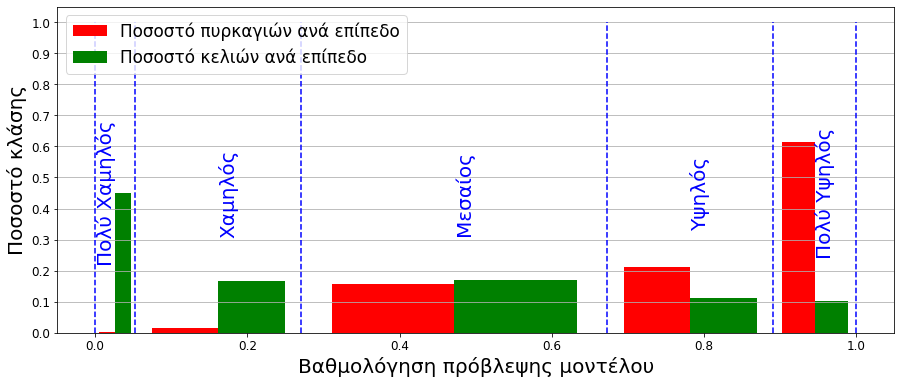

In [11]:
binscust=[0, 0.052360608171, 0.270555242059, 0.67285159829, 0.8910462321779999, 1]
plotfiredistrib=dfeval.loc[dfeval['fire']==1]['ypred1'].values
plotalldistrib=dfeval['ypred1'].values
fig1, ax1 = plt.subplots(1, 1, figsize=(15,6))
fsize=20
#ax1.set_title('Model performance during 2023 fire season', fontsize=fsize+2)

#ax1.title.set_text('Distribution of ypred')
h50, be50 = np.histogram(plotfiredistrib, bins=50)
hcustf, becustf = np.histogram(plotfiredistrib, bins=binscust)
hcustnf, becustnf = np.histogram(plotalldistrib, bins=binscust)
#ax1.hist(plotalldistrib, bins=100)
#ax1.hist(plotfiredistrib, bins=50, weights=np.ones(len(plotfiredistrib)) / len(plotfiredistrib))
#ax1.plot(be50[1:],np.cumsum(h50)/sum(h50),label="Cumul.Prob.Distrib. of model's pred. 'fire' class", linewidth=3)
#ax1.plot(be50[:-1],h50/sum(h50),label="Prob. Distribution of model's prediction for 'fire'", linewidth=3)
#ax1.plot(becustf[1:],np.cumsum(hcustf)/sum(hcustf),label="Cumul.Prob.Distrib. of Risk Level for 'fire' class",marker='o', linewidth=3)
#ax1.plot(becustnf[:-1],np.cumsum(hcustnf)/sum(hcustnf),label='Level pred. vs all rate',marker='o')
#ax1.plot(be50[:-1],be50[1:],linestyle='--', color='black', label='Ideal Probability match')
#ax1.set_xlabel('Prediction score', fontsize=fsize)
ax1.yaxis.set_ticks(np.linspace(0,1, 11).astype(float))
ax1.grid(axis='y')
ax1.set_xlabel('Βαθμολόγηση πρόβλεψης μοντέλου', fontsize=fsize)
ax1.set_ylabel('Ποσοστό κλάσης', fontsize=fsize)
#ax1.set_ylabel('Class percentage', fontsize=fsize)
ax1.tick_params(axis='both', labelsize=12)

#ax2=ax1.twinx()
#ax2.set_ylabel('Times x Cond. Prob. of fire given level 1')
#ax2.set_yscale('log')
#ax2.plot(becustf[:-1],pfrate,label='Cond. Prob. of fire given level (right y axis)',color='purple')

colors1 = ['red', 'darkorange','yellow', 'green', 'blue']
colors2 = ['tomato', 'orange','gold', 'lightgreen', 'lightblue']

#.reverse()

#colors
N, bins, patches = ax1.hist([plotfiredistrib,plotalldistrib], bins=binscust,
                             weights=[np.ones(len(plotfiredistrib)) / len(plotfiredistrib), 
                                      np.ones(len(plotalldistrib)) / len(plotalldistrib)], color=['red', 'green'],
                            label=['Ποσοστό πυρκαγιών ανά επίπεδο', 'Ποσοστό κελιών ανά επίπεδο'])
                           #label=['Actual "Fire" rate per risk level', 'All cells rate per risk level'])


#labels = [w.get_text() for w in ax1.get_xticklabels()]
#locs=list(ax1.get_xticks())
#llabels=['Very Low', 'Low', 'Moderate', 'High', 'Very High']
llabels=['Πολύ Χαμηλός', 'Χαμηλός', 'Μεσαίος', 'Υψηλός', 'Πολύ Υψηλός']
#locs+=binscust[1:]
#ax1.set_xticklabels(labels)
#ax1.set_xticks(locs)

plt.vlines(x=binscust, ymin=0, ymax=1, color = 'b', linestyle='--')

prev=-0.05
for i, x in enumerate(binscust[1:]):
    #print(x, prev, (x-prev)/2 )
    ax1.text(x-(x-prev)/2, 0.45, llabels[i], rotation=90, verticalalignment='center', color='blue', fontsize=fsize)
    prev=x

#lines, labels = ax1.get_legend_handles_labels()
#lines2, labels2 = ax2.get_legend_handles_labels()
#ax2.legend(lines + lines2, labels + labels2, loc='upper left')
ax1.legend(fontsize=fsize-3, loc='upper left')
#N, bins, patches2 = ax1.hist(plotalldistrib, bins=binscust, weights=np.ones(len(plotalldistrib)) / len(plotalldistrib))
          #alpha=0.7, color=colors, edgecolor='black')

#for patch, color in zip(patches[0], colors1[::-1]):
#    patch.set_facecolor(color)
#for patch, color in zip(patches[1], colors2[::-1]):
#    patch.set_facecolor(color)

#patches
#for i in range(0,5):
#    patches[i].set_facecolor(colors[::-1][i])
#plt.legend()
plt.show()